In [1]:
import os.path as osp

from collections import namedtuple
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

import pyg_lib
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.loader import ClusterData, ClusterLoader
from torch_geometric.datasets import Planetoid
from torch_geometric.nn.models import GraphSAGE

The Cora dataset consists of __2708 scientific publications__ classified into one of __seven classes (y vector)__. The citation network consists of 5429 links. Each publication in the dataset is described by a 0/1-valued word vector indicating the absence/presence of the corresponding word from the dictionary. The dictionary consists of __1433 unique words (x matrix)__.
![cora](static/Cora.png) 

In [2]:
dataset_directory = '/notebooks/data'
dataset = Planetoid(dataset_directory, 'Cora')
data = dataset[0]

Processing...
Done!


In [3]:
model = GraphSAGE(in_channels=1433, 
                  hidden_channels=128,
                  num_layers=3)
print(model)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)

GraphSAGE(1433, 128, num_layers=3)


/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


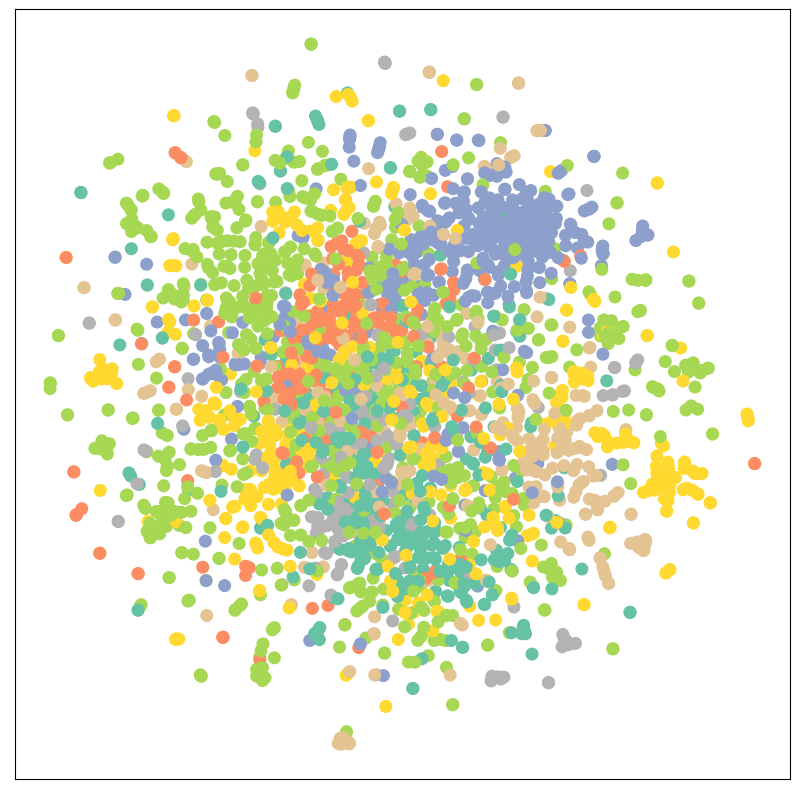

In [4]:
def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()
    
model.eval()
out = model(data.x, data.edge_index)
visualize(out, color=data.y)

In [5]:
def train():
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    out = model(data.x, data.edge_index)  # Perform a single forward pass.
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss

def test():
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
    return test_acc


for epoch in range(1, 101):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 001, Loss: 4.8783
Epoch: 002, Loss: 4.8175
Epoch: 003, Loss: 4.7641
Epoch: 004, Loss: 4.7070
Epoch: 005, Loss: 4.6358
Epoch: 006, Loss: 4.5414
Epoch: 007, Loss: 4.4164
Epoch: 008, Loss: 4.2534
Epoch: 009, Loss: 4.0450
Epoch: 010, Loss: 3.7835
Epoch: 011, Loss: 3.4630
Epoch: 012, Loss: 3.0843
Epoch: 013, Loss: 2.6632
Epoch: 014, Loss: 2.2425
Epoch: 015, Loss: 1.8891
Epoch: 016, Loss: 1.6423
Epoch: 017, Loss: 1.4751
Epoch: 018, Loss: 1.3455
Epoch: 019, Loss: 1.2377
Epoch: 020, Loss: 1.1486
Epoch: 021, Loss: 1.0694
Epoch: 022, Loss: 0.9851
Epoch: 023, Loss: 0.8847
Epoch: 024, Loss: 0.7763
Epoch: 025, Loss: 0.6794
Epoch: 026, Loss: 0.5999
Epoch: 027, Loss: 0.5274
Epoch: 028, Loss: 0.4549
Epoch: 029, Loss: 0.3840
Epoch: 030, Loss: 0.3199
Epoch: 031, Loss: 0.2676
Epoch: 032, Loss: 0.2272
Epoch: 033, Loss: 0.1934
Epoch: 034, Loss: 0.1624
Epoch: 035, Loss: 0.1343
Epoch: 036, Loss: 0.1106
Epoch: 037, Loss: 0.0919
Epoch: 038, Loss: 0.0771
Epoch: 039, Loss: 0.0649
Epoch: 040, Loss: 0.0548


Test Accuracy: 0.8010


/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


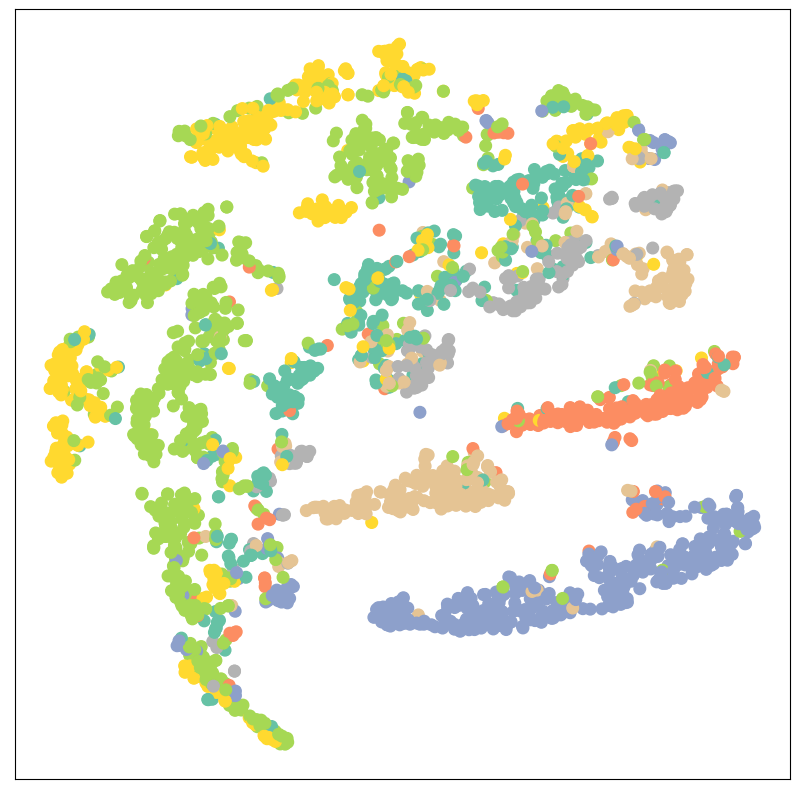

In [6]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

***

In [8]:
total_num_clusters = 150

cluster_data = ClusterData(
    dataset[0], num_parts=total_num_clusters)

Computing METIS partitioning...
Done!


In [9]:
num_nodes_per_cluster = []
num_edges_per_cluster = []

for cluster in cluster_data:
    num_nodes_per_cluster.append(cluster.y.shape[0])
    num_edges_per_cluster.append(cluster.edge_index.shape[1])

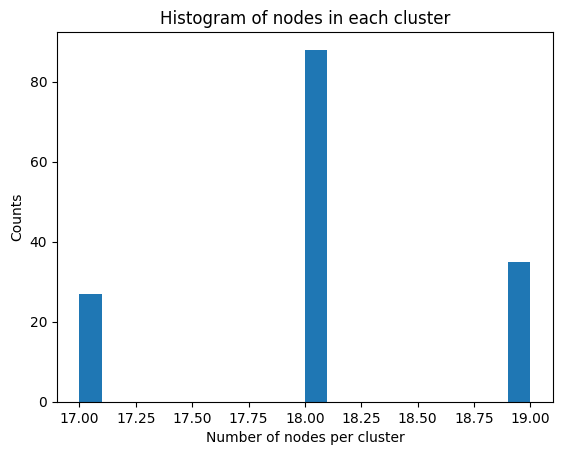

In [10]:
plt.hist(np.array(num_nodes_per_cluster), 20)
plt.xlabel("Number of nodes per cluster")
plt.ylabel("Counts")
plt.title("Histogram of nodes in each cluster")
plt.show()

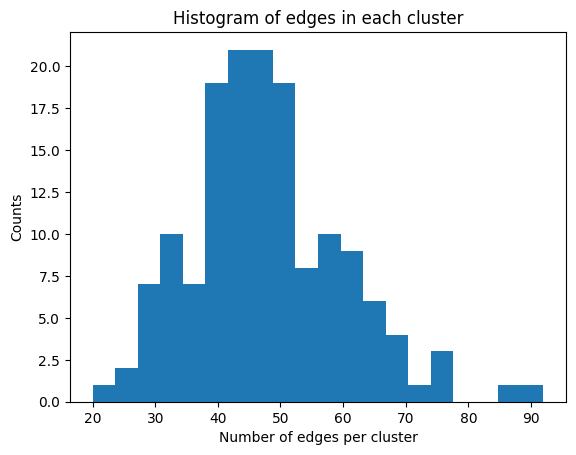

In [11]:
plt.hist(np.array(num_edges_per_cluster), 20)
plt.xlabel("Number of edges per cluster")
plt.ylabel("Counts")
plt.title("Histogram of edges in each cluster")
plt.show()

In [12]:
clusters_per_batch = 10

dynamic_size_dataloader = ClusterLoader(
    cluster_data,
    batch_size=clusters_per_batch,
)

dynamic_size_dataloader

In [29]:
model = GraphSAGE(in_channels=1433, 
                  hidden_channels=256,
                  num_layers=3)
print(model)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)

GraphSAGE(1433, 256, num_layers=3)


In [30]:
def epoch_train(model):
    model.train()
    for batch in dynamic_size_dataloader:
        optimizer.zero_grad()  # Clear gradients.
        out = model(batch.x, batch.edge_index)  # Perform a single forward pass.
        loss = criterion(out[batch.train_mask], batch.y[batch.train_mask])  # Compute the loss solely based on the training nodes.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
    return loss


for epoch in range(1, 35):
    loss = epoch_train(model)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 001, Loss: 3.1593
Epoch: 002, Loss: 1.6282
Epoch: 003, Loss: 1.2322
Epoch: 004, Loss: 0.5269
Epoch: 005, Loss: 0.1345
Epoch: 006, Loss: 0.0382
Epoch: 007, Loss: 0.0164
Epoch: 008, Loss: 0.0098
Epoch: 009, Loss: 0.0066
Epoch: 010, Loss: 0.0049
Epoch: 011, Loss: 0.0037
Epoch: 012, Loss: 0.0030
Epoch: 013, Loss: 0.0024
Epoch: 014, Loss: 0.0020
Epoch: 015, Loss: 0.0017
Epoch: 016, Loss: 0.0015
Epoch: 017, Loss: 0.0013
Epoch: 018, Loss: 0.0012
Epoch: 019, Loss: 0.0010
Epoch: 020, Loss: 0.0010
Epoch: 021, Loss: 0.0009
Epoch: 022, Loss: 0.0010
Epoch: 023, Loss: 0.0008
Epoch: 024, Loss: 0.0010
Epoch: 025, Loss: 0.0007
Epoch: 026, Loss: 0.0010
Epoch: 027, Loss: 0.0007
Epoch: 028, Loss: 0.0010
Epoch: 029, Loss: 0.0007
Epoch: 030, Loss: 0.0010
Epoch: 031, Loss: 0.0007
Epoch: 032, Loss: 0.0011
Epoch: 033, Loss: 0.0007
Epoch: 034, Loss: 0.0012


In [31]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.8090


/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


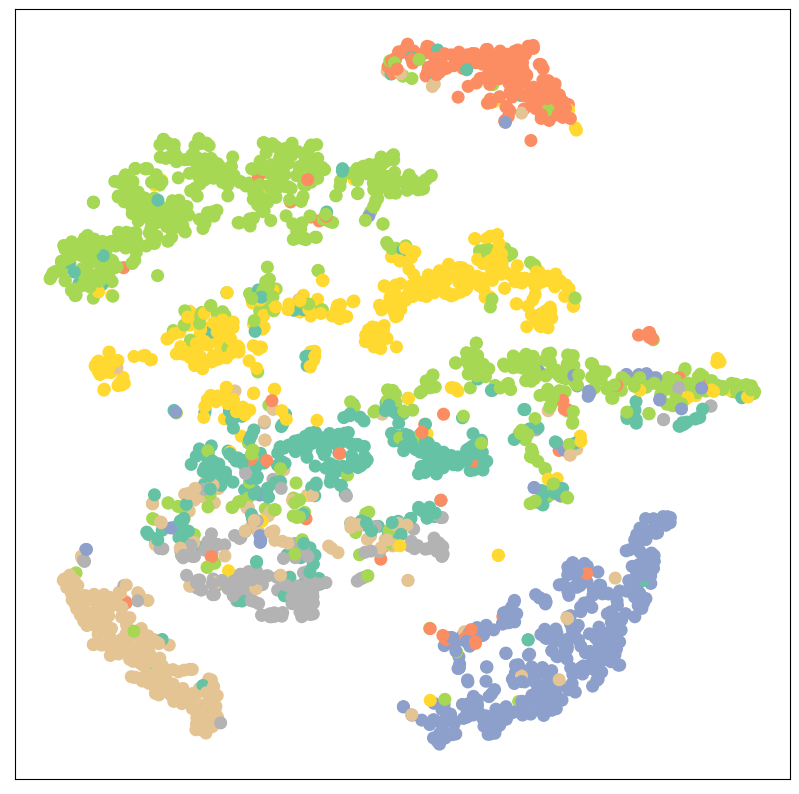

In [32]:
out = model(data.x, data.edge_index)
visualize(out, color=data.y)